In [1]:
import torch
from torch import nn
from torch import optim
from torch import autograd
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np

from reptile_omniglotNShot import OmniglotNShot
from reptile_naive import Naive
from torch.utils.tensorboard import SummaryWriter

In [2]:
class Learner(nn.Module):
    """
    This is a learner class, which will accept a specific network module, such as OmniNet that define the network forward
    process. Learner class will create two same network, one as theta network and the other acts as theta_pi network.
    for each episode, the theta_pi network will copy its initial parameters from theta network and update several steps
    by meta-train set and then calculate its loss on meta-test set. All loss on meta-test set will be sumed together and
    then backprop on theta network, which should be done on metalaerner class.
    For learner class, it will be responsible for update for several steps on meta-train set and return with the loss on
    meta-test set.
    """
    def __init__(self, net_cls, *args):
        """
        It will receive a class: net_cls and its parameters: args for net_cls.
        :param net_cls: class, not instance
        :param args: the parameters for net_cls
        """
        super(Learner, self).__init__()
        # pls make sure net_cls is a class but NOT an instance of class.
        assert net_cls.__class__ == type
        
        # we will create two class instance meanwhile and use one as theta network and the other as theta_pi network.
        self.net = net_cls(*args)
        self.net_pi = net_cls(*args)
        
        # update theta_pi = theta_pi - lr * grad
        # according to the paper, here we use naive version of SGD to update theta_pi
        # 0.1 here means the learner_lr
        self.optimizer = optim.SGD(self.net_pi.parameters(), 0.1)
        
    def parameters(self):
        """
        Override this function to return only net parameters for MetaLearner's optimize
        it will ignore theta_pi network parameters.
        :return:
        """
        return self.net.parameters()
    
    def update_pi(self):
        """
        copy parameters from self.net -> self.net_pi
        :return:
        """
        for m_from, m_to in zip(self.net.modules(), self.net_pi.modules()):
            if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv2d) or isinstance(m_to, nn.BatchNorm2d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()
                    
    def forward(self, support_x, support_y, query_x, query_y, num_updates):
        """
        learn on current episode meta-train: support_x & support_y and then calculate loss on meta-test set: query_x&y
        :param support_x: [setsz, c_, h, w]
        :param support_y: [setsz]
        :param query_x:   [querysz, c_, h, w]
        :param query_y:   [querysz]
        :param num_updates: 5
        :return:
        """
        
        # now try to fine-tune from current $theta$ parameters -> $theta_pi$
        # after num_updates of fine-tune, we will get a good theta_pi parameters so that it will retain satisfying
        # performance on specific task, that's, current episode.
        # firstly, copy theta_pi from theta network
        self.update_pi()
        
        # update for several steps
        for i in range(num_updates):
            # forward and backward to update net_pi grad.
            loss, pred = self.net_pi(support_x, support_y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        # Compute the meta gradient and return it, the gradient is from one episode
        # in metalearner, it will merge all loss from different episode and sum over it.
        loss, pred = self.net_pi(query_x, query_y)
        # pred: [setsz, n_way], indices: [setsz]
        _, indices = torch.max(pred, dim=1)
#         correct = torch.eq(indices, query_y).sum().data[0]
        correct = torch.eq(indices, query_y).sum().item()
        acc = correct / query_y.size(0)
        
        # gradient for validation on theta_pi
        # after call autorad.grad, you can not call backward again except for setting create_graph = True
        # as we will use the loss as dummpy loss to conduct a dummy backprop to write our gradients to theta network,
        # here we set create_graph to true to support second time backward.
        grads_pi = autograd.grad(loss, self.net_pi.parameters(), create_graph=True)

        return loss, grads_pi, acc
    
    def net_forward(self, support_x, support_y):
        """
        This function is purely for updating net network. In metalearner, we need the get the loss op from net network
        to write our merged gradients into net network, hence will call this function to get a dummy loss op.
        :param support_x: [setsz, c, h, w]
        :param support_y: [sessz, c, h, w]
        :return: dummy loss and dummy pred
        """
        loss, pred = self.net(support_x, support_y)
        return loss, pred

In [3]:
class MetaLearner(nn.Module):
    """
    As we have mentioned in Learner class, the metalearner class will receive a series of loss on different tasks/episodes
    on theta_pi network, and it will merage all loss and then sum over it. The summed loss will be backproped on theta
    network to update theta parameters, which is the initialization point we want to find.
    """
    
    def __init__(self, net_cls, net_cls_args, n_way, k_shot, meta_batchsz, beta, num_updates):
        """
        :param net_cls: class, not instance. the class of specific Network for learner
        :param net_cls_args: tuple, args for net_cls, like (n_way, imgsz)
        :param n_way:
        :param k_shot:
        :param meta_batchsz: number of tasks/episode
        :param beta: learning rate for meta-learner
        :param num_updates: number of updates for learner
        """
        super(MetaLearner, self).__init__()

        self.n_way = n_way
        self.k_shot = k_shot
        self.meta_batchsz = meta_batchsz
        self.beta = beta
        # self.alpha = alpha # set alpha in Learner.optimizer directly.
        self.num_updates = num_updates

        # it will contains a learner class to learn on episodes and gather the loss together.
        self.learner = Learner(net_cls, *net_cls_args)
        # the optimizer is to update theta parameters, not theta_pi parameters.
        self.optimizer = optim.Adam(self.learner.parameters(), lr=beta)
        
    def write_grads(self, dummy_loss, sum_grads_pi):
        """
        write loss into learner.net, gradients come from sum_grads_pi.
        Since the gradients info is not calculated by general backward, we need this function to write the right gradients
        into theta network and update theta parameters as wished.
        :param dummy_loss: dummy loss, nothing but to write our gradients by hook
        :param sum_grads_pi: the summed gradients
        :return:
        """

        # Register a hook on each parameter in the net that replaces the current dummy grad
        # with our grads accumulated across the meta-batch
        hooks = []

        for i, v in enumerate(self.learner.parameters()):
            def closure():
                ii = i
                return lambda grad: sum_grads_pi[ii]

            # if you write: hooks.append( v.register_hook(lambda grad : sum_grads_pi[i]) )
            # it will pop an ERROR, i don't know why?
            hooks.append(v.register_hook(closure()))

        # use our sumed gradients_pi to update the theta/net network,
        # since our optimizer receive the self.net.parameters() only.
        self.optimizer.zero_grad()
        dummy_loss.backward()
        self.optimizer.step()

        # if you do NOT remove the hook, the GPU memory will expode!!!
        for h in hooks:
            h.remove()
            
    def forward(self, support_x, support_y, query_x, query_y):
        """
        Here we receive a series of episode, each episode will be learned by learner and get a loss on parameters theta.
        we gather the loss and sum all the loss and then update theta network.
        setsz = n_way * k_shotf
        querysz = n_way * k_shot
        :param support_x: [meta_batchsz, setsz, c_, h, w]
        :param support_y: [meta_batchsz, setsz]
        :param query_x:   [meta_batchsz, querysz, c_, h, w]
        :param query_y:   [meta_batchsz, querysz]
        :return:
        """
        sum_grads_pi = None
        meta_batchsz = support_y.size(0)

        # support_x[i]: [setsz, c_, h, w]
        # we do different learning task sequentially, not parallel.
        accs = []
        # for each task/episode.
        for i in range(meta_batchsz):
            _, grad_pi, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates)
            accs.append(episode_acc)
            if sum_grads_pi is None:
                sum_grads_pi = grad_pi
            else:  # accumulate all gradients from different episode learner
                sum_grads_pi = [torch.add(i, j) for i, j in zip(sum_grads_pi, grad_pi)]

        # As we already have the grads to update
        # We use a dummy forward / backward pass to get the correct grads into self.net
        # the right grads will be updated by hook, ignoring backward.
        # use hook mechnism to write sumed gradient into network.
        # we need to update the theta/net network, we need a op from net network, so we call self.learner.net_forward
        # to get the op from net network, since the loss from self.learner.forward will return loss from net_pi network.
        dummy_loss, _ = self.learner.net_forward(support_x[0], support_y[0])
        self.write_grads(dummy_loss, sum_grads_pi)

        return accs
    
    def pred(self, support_x, support_y, query_x, query_y):
        """
        predict for query_x
        :param support_x:
        :param support_y:
        :param query_x:
        :param query_y:
        :return:
        """
        meta_batchsz = support_y.size(0)

        accs = []
        # for each task/episode.
        # the learner will copy parameters from current theta network and then fine-tune on support set.
        for i in range(meta_batchsz):
            _, _, episode_acc = self.learner(support_x[i], support_y[i], query_x[i], query_y[i], self.num_updates)
            accs.append(episode_acc)

        return np.array(accs).mean()

In [4]:
meta_batchsz = 32
n_way = 5
k_shot = 1
k_query = k_shot
meta_lr = 1e-3
num_updates = 5
dataset = 'omniglot'

imgsz = 28
db = OmniglotNShot('dataset', batchsz=meta_batchsz, n_way=n_way, k_shot=k_shot, k_query=k_query, imgsz=imgsz)
meta = MetaLearner(Naive, (n_way, imgsz), n_way=n_way, k_shot=k_shot, meta_batchsz=meta_batchsz, beta=meta_lr,
                   num_updates=num_updates).cuda()

tb = SummaryWriter('runs')

# main loop
for episode_num in range(200000):
    # 1. train
    support_x, support_y, query_x, query_y = db.get_batch('test')
    support_x = Variable( torch.from_numpy(support_x).float().transpose(2, 4).transpose(3, 4).repeat(1, 1, 3, 1, 1)).cuda()
    query_x = Variable( torch.from_numpy(query_x).float().transpose(2, 4).transpose(3, 4).repeat(1, 1, 3, 1, 1)).cuda()
    support_y = Variable(torch.from_numpy(support_y).long()).cuda()
    query_y = Variable(torch.from_numpy(query_y).long()).cuda()

    # backprop has been embeded in forward func.
    accs = meta(support_x, support_y, query_x, query_y)
    train_acc = np.array(accs).mean()
    
    # 2. test
    if episode_num % 30 == 0:
        test_accs = []
        for i in range(min(episode_num // 5000 + 3, 10)): # get average acc.
            support_x, support_y, query_x, query_y = db.get_batch('test')
            support_x = Variable( torch.from_numpy(support_x).float().transpose(2, 4).transpose(3, 4).repeat(1, 1, 3, 1, 1)).cuda()
            query_x = Variable( torch.from_numpy(query_x).float().transpose(2, 4).transpose(3, 4).repeat(1, 1, 3, 1, 1)).cuda()
            support_y = Variable(torch.from_numpy(support_y).long()).cuda()
            query_y = Variable(torch.from_numpy(query_y).long()).cuda()
            
            # get accuracy
            test_acc = meta.pred(support_x, support_y, query_x, query_y)
            test_accs.append(test_acc)
            
        test_acc = np.array(test_accs).mean()
        print('episode:', episode_num, '\tfinetune acc:%.6f' % train_acc, '\t\ttest acc:%.6f' % test_acc)
        tb.add_scalar('test-acc', test_acc)
        tb.add_scalar('finetune-acc', train_acc)

before norm: mean 0.9187823248049223 max 1.0 min 0.0 std 0.21980729156739412
after norm: mean -1.4055967274460421e-15 max 0.36949490899930376 min -4.179944706353012 std 0.9999999999999992
train_shape (1200, 20, 28, 28, 1) test_shape (423, 20, 28, 28, 1)
Naive(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2

episode: 3060 	finetune acc:0.987500 		test acc:0.943750
episode: 3090 	finetune acc:0.950000 		test acc:0.918750
episode: 3120 	finetune acc:0.950000 		test acc:0.945833
episode: 3150 	finetune acc:0.956250 		test acc:0.954167
episode: 3180 	finetune acc:0.937500 		test acc:0.962500
episode: 3210 	finetune acc:0.968750 		test acc:0.958333
episode: 3240 	finetune acc:0.968750 		test acc:0.947917
episode: 3270 	finetune acc:0.937500 		test acc:0.947917
episode: 3300 	finetune acc:0.943750 		test acc:0.958333
episode: 3330 	finetune acc:0.931250 		test acc:0.943750
episode: 3360 	finetune acc:0.925000 		test acc:0.947917
episode: 3390 	finetune acc:0.937500 		test acc:0.958333
episode: 3420 	finetune acc:0.950000 		test acc:0.945833
episode: 3450 	finetune acc:0.962500 		test acc:0.941667
episode: 3480 	finetune acc:0.956250 		test acc:0.939583
episode: 3510 	finetune acc:0.931250 		test acc:0.952083
episode: 3540 	finetune acc:0.943750 		test acc:0.958333
episode: 3570 	finetune acc:0.9

episode: 7380 	finetune acc:0.981250 		test acc:0.976563
episode: 7410 	finetune acc:0.968750 		test acc:0.971875
episode: 7440 	finetune acc:0.968750 		test acc:0.951562
episode: 7470 	finetune acc:0.962500 		test acc:0.973437
episode: 7500 	finetune acc:0.975000 		test acc:0.965625
episode: 7530 	finetune acc:0.975000 		test acc:0.971875
episode: 7560 	finetune acc:0.943750 		test acc:0.978125
episode: 7590 	finetune acc:0.962500 		test acc:0.978125
episode: 7620 	finetune acc:0.931250 		test acc:0.975000
episode: 7650 	finetune acc:0.981250 		test acc:0.957812
episode: 7680 	finetune acc:0.975000 		test acc:0.967187
episode: 7710 	finetune acc:0.937500 		test acc:0.971875
episode: 7740 	finetune acc:0.968750 		test acc:0.970312
episode: 7770 	finetune acc:0.962500 		test acc:0.965625
episode: 7800 	finetune acc:0.962500 		test acc:0.956250
episode: 7830 	finetune acc:0.956250 		test acc:0.948437
episode: 7860 	finetune acc:0.950000 		test acc:0.957812
episode: 7890 	finetune acc:0.9

KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt

In [2]:
import os

In [6]:
with open('omniglot_train.txt','r') as f:
    data = f.read().splitlines()
    data = [line.split('\t') for line in data]
episode = [int(line[0].split(':')[1]) for line in data]
train_acc = [float(line[1].split(':')[1]) for line in data]
test_acc = [float(line[3].split(':')[1]) for line in data]

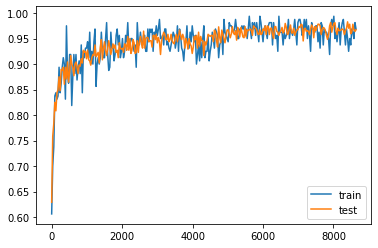

In [10]:
plt.plot(episode, train_acc, label='train')
plt.plot(episode, test_acc, label='test')
plt.legend()